Using device: mps


Loading Stable Diffusion model:   0%|          | 0/1 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/opt/homebrew/lib/python3.11/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Loading and preprocessing images:   0%|          | 0/2 [00:00<?, ?it/s]

Processed size of image1: (256, 256), Original size: (256, 256)
Processed size of image2: (256, 256), Original size: (256, 256)


Encoding images to latent representations:   0%|          | 0/2 [00:00<?, ?it/s]

Shape of latents1: torch.Size([1, 4, 32, 32])
Shape of latents2: torch.Size([1, 4, 32, 32])
Interpolating between latents...


Interpolating and Decoding:   0%|          | 0/20 [00:00<?, ?it/s]

Interpolation complete. 20 images generated and saved in diffusion-output
Plotting results...


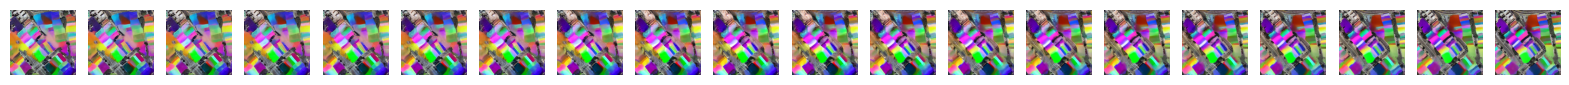

In [3]:
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from diffusers import StableDiffusionPipeline, DDIMScheduler
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

# Parameters
MODEL_ID = "Jiali/stable-diffusion-1.5"
IMAGE1_PATH = "../data/results/ma_boston_200336_fake_B.png"
IMAGE2_PATH = "../data/results/ny_manhattan_200250_fake_B.png"
OUTPUT_DIR = "diffusion-output"
NUM_STEPS = 20
INFERENCE_STEPS = 50

# Set device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

def slerp(val, low, high):
    """Spherical linear interpolation for 4D tensors."""
    low_2d = low.view(low.shape[0], -1)
    high_2d = high.view(high.shape[0], -1)
    low_2d_norm = low_2d / torch.norm(low_2d, dim=1, keepdim=True)
    high_2d_norm = high_2d / torch.norm(high_2d, dim=1, keepdim=True)
    omega = torch.acos((low_2d_norm * high_2d_norm).sum(1).clamp(-1, 1))
    so = torch.sin(omega)
    res = (torch.sin((1.0 - val) * omega) / so).unsqueeze(1) * low_2d + \
          (torch.sin(val * omega) / so).unsqueeze(1) * high_2d
    return res.view(low.shape)

def load_and_preprocess_image(image_path):
    # Open the image and convert to RGB
    image = Image.open(image_path).convert("RGB")
    
    # Get the original size
    original_size = image.size
    
    # Calculate the aspect ratio
    aspect_ratio = original_size[0] / original_size[1]
    
    # Determine the new size (ensuring it's divisible by 8 for the VAE)
    if aspect_ratio > 1:
        new_width = min(original_size[0], 768)
        new_width = new_width - (new_width % 8)
        new_height = int(new_width / aspect_ratio)
        new_height = new_height - (new_height % 8)
    else:
        new_height = min(original_size[1], 768)
        new_height = new_height - (new_height % 8)
        new_width = int(new_height * aspect_ratio)
        new_width = new_width - (new_width % 8)
    
    new_size = (new_width, new_height)
    
    # Create the transform
    transform = Compose([
        Resize(new_size),
        ToTensor(),
        Normalize([0.5], [0.5])
    ])
    
    # Apply the transform
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    return image_tensor, new_size, original_size

try:
    # Load the pre-trained Stable Diffusion model with DDIM scheduler
    with tqdm(total=1, desc="Loading Stable Diffusion model") as pbar:
        scheduler = DDIMScheduler.from_pretrained(MODEL_ID, subfolder="scheduler")
        pipe = StableDiffusionPipeline.from_pretrained(MODEL_ID, scheduler=scheduler, torch_dtype=torch.float32)
        pipe = pipe.to(device)
        if device.type == "cuda":
            pipe.enable_attention_slicing()
        pbar.update(1)

    # Load and preprocess images
    with tqdm(total=2, desc="Loading and preprocessing images") as pbar:
        image1, size1, original_size1 = load_and_preprocess_image(IMAGE1_PATH)
        pbar.update(1)
        image2, size2, original_size2 = load_and_preprocess_image(IMAGE2_PATH)
        pbar.update(1)

    print(f"Processed size of image1: {size1}, Original size: {original_size1}")
    print(f"Processed size of image2: {size2}, Original size: {original_size2}")

    # Encode images to latents
    with tqdm(total=2, desc="Encoding images to latent representations") as pbar:
        with torch.no_grad():
            latents1 = pipe.vae.encode(image1).latent_dist.sample() * 0.18215
            pbar.update(1)
            latents2 = pipe.vae.encode(image2).latent_dist.sample() * 0.18215
            pbar.update(1)

    print(f"Shape of latents1: {latents1.shape}")
    print(f"Shape of latents2: {latents2.shape}")

    # Interpolate between latents
    print("Interpolating between latents...")
    alphas = np.linspace(0, 1, NUM_STEPS)
    interpolated_images = []
    
    with tqdm(total=NUM_STEPS, desc="Interpolating and Decoding") as pbar:
        for alpha in alphas:
            interpolated_latent = slerp(alpha, latents1, latents2)
            with torch.no_grad():
                # Scale the latents
                interpolated_latent = 1 / 0.18215 * interpolated_latent
                # Decode the latents
                decoded_image = pipe.vae.decode(interpolated_latent).sample
                # Normalize the decoded image
                decoded_image = (decoded_image / 2 + 0.5).clamp(0, 1)
                # Convert to CPU and then to numpy array
                decoded_image = decoded_image.cpu().permute(0, 2, 3, 1).numpy()[0]
            
            # Convert to PIL Image
            decoded_image_pil = Image.fromarray((decoded_image * 255).astype(np.uint8))
            # Resize the output image to the original size of the first image
            decoded_image_pil = decoded_image_pil.resize(original_size1, Image.LANCZOS)
            
            interpolated_images.append(decoded_image_pil)
            
            # Save the interpolated image
            os.makedirs(OUTPUT_DIR, exist_ok=True)
            output_path = os.path.join(OUTPUT_DIR, f"interpolated_{len(interpolated_images)}.png")
            decoded_image_pil.save(output_path, quality=95)
            
            pbar.update(1)

    print(f"Interpolation complete. {NUM_STEPS} images generated and saved in {OUTPUT_DIR}")

    # Plot results
    print("Plotting results...")
    fig, axes = plt.subplots(1, NUM_STEPS, figsize=(20, 4))
    for ax, img in zip(axes, interpolated_images):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")